[*********************100%%**********************]  5 of 5 completed


MSE for AAPL: 46.4233


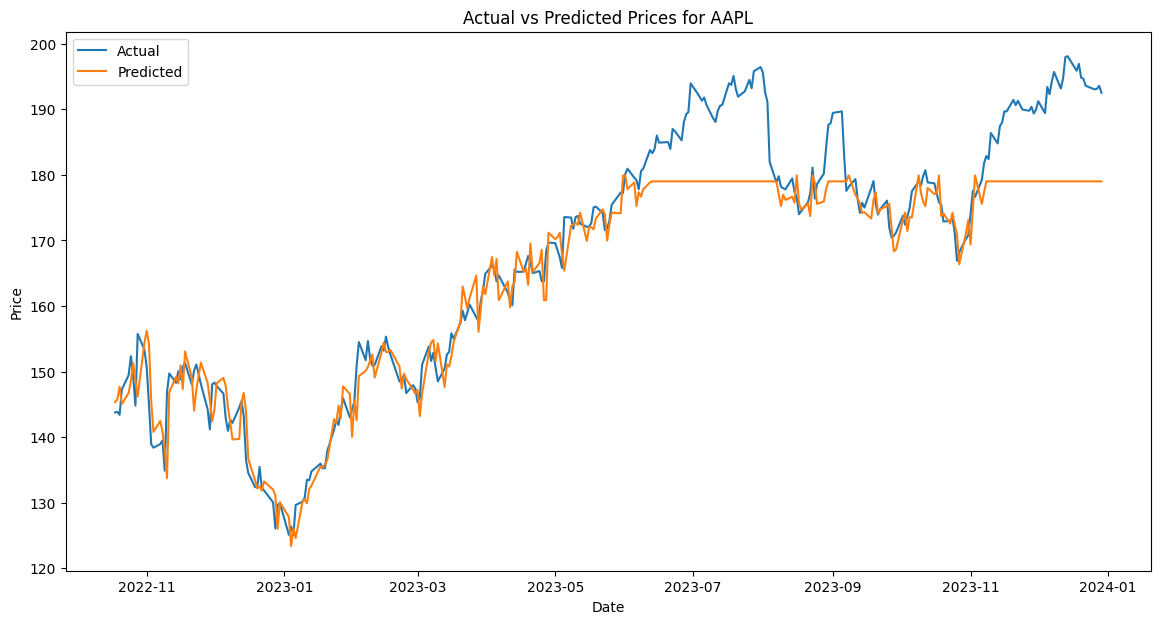

MSE for MSFT: 169.6612


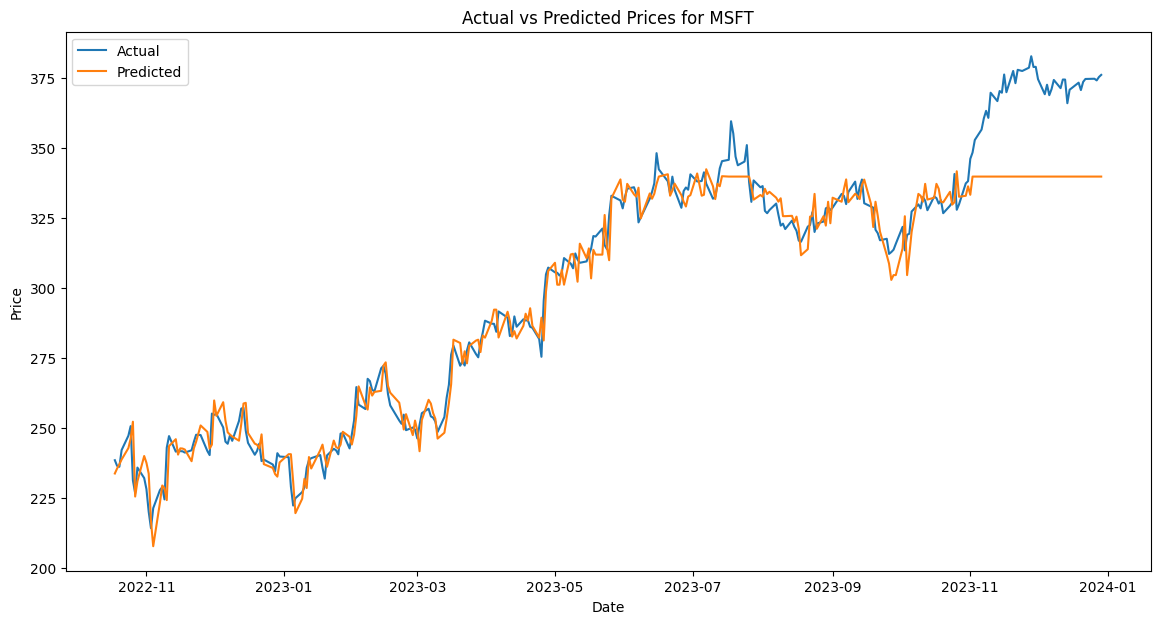

MSE for GOOGL: 7.9408


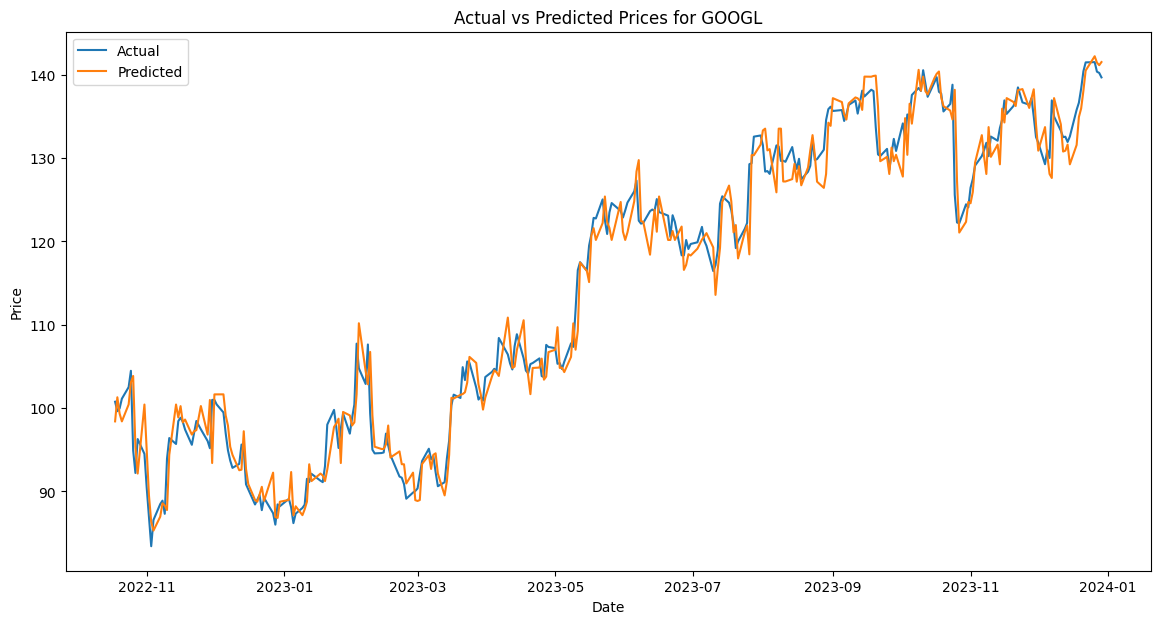

MSE for AMZN: 11.9275


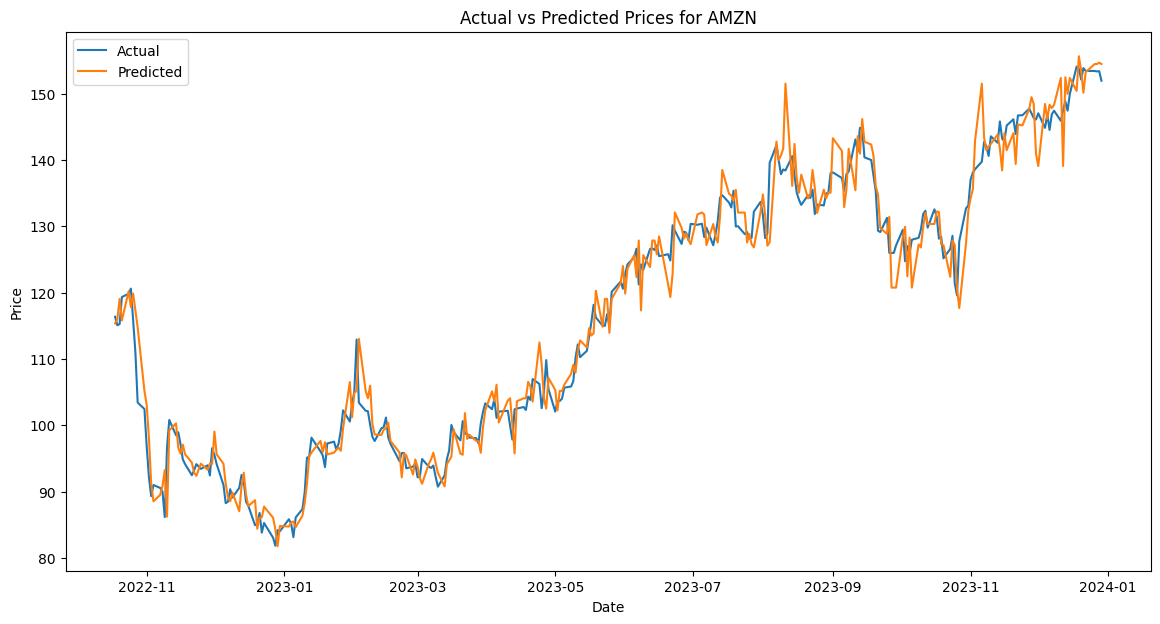

MSE for TSLA: 130.8346


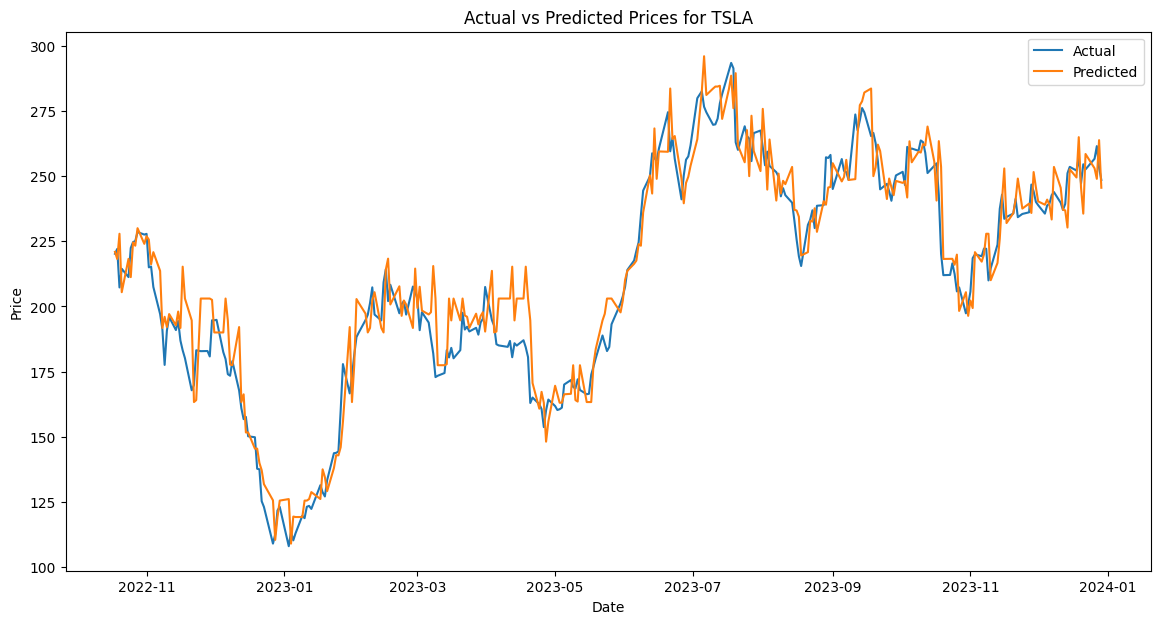

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Download Stock Data
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = yf.download(stocks, start="2018-01-01", end="2023-12-31")

# Prepare the Data
data_close = data['Close']

# Dictionary to store models and predictions
models = {}
predictions = {}
mse_values = {}

# Train a Random Forest model for each stock
for stock in stocks:
    stock_data = data_close[[stock]].dropna()
    stock_data['Returns'] = stock_data[stock].pct_change().dropna()

    #Feature: Previous day's closing price
    stock_data['Lag1'] = stock_data[stock].shift(1)
    stock_data = stock_data.dropna()

    # Features and target
    X = stock_data[['Lag1']]
    y = stock_data[stock]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Store the model and predictions
    models[stock] = model
    predictions[stock] = (y_test, y_pred)

    # Calculate MSE for the stock
    mse = mean_squared_error(y_test, y_pred)
    mse_values[stock] = mse
    
    # Print the MSE for the stock
    print(f"MSE for {stock}: {mse:.4f}")

    # Plot actual vs predicted prices
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.title(f'Actual vs Predicted Prices for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show() 

Metric                   Optimal        Max/Min        
-------------------------------------------------------
Return                   0.3850         0.4643         
Std Deviation            0.3027         0.2611         
Sharpe Ratio             1.2721         1.2721         

Optimal Portfolio Weights:
AAPL: 6.25%
MSFT: 47.37%
GOOGL: 24.64%
AMZN: 13.24%
TSLA: 8.50%


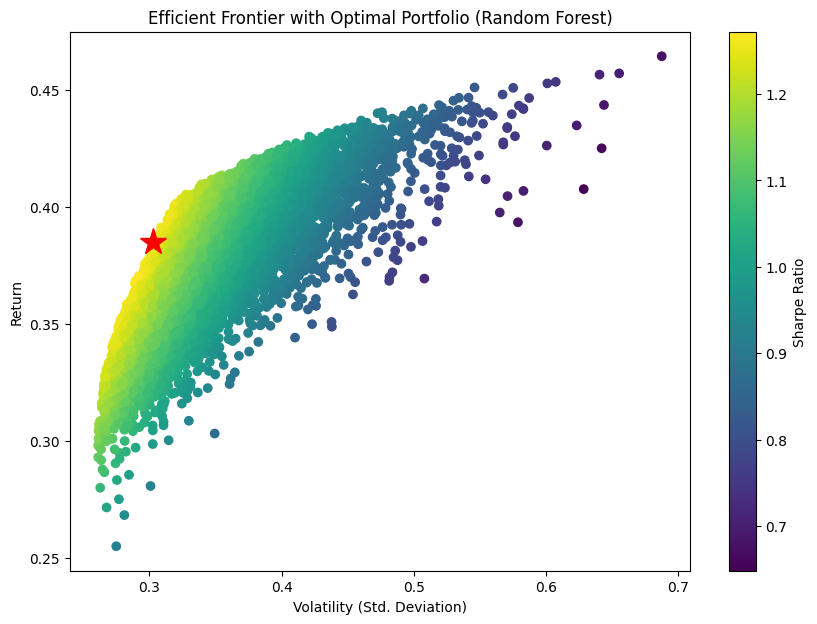

In [3]:

# Calculate returns from the predicted prices
predicted_prices_df = pd.DataFrame({stock: predictions[stock][1] for stock in stocks}, index=y_test.index)
predicted_returns = predicted_prices_df.pct_change().dropna()

# Mean returns and covariance matrix from predicted returns
mean_returns = predicted_returns.mean()
cov_matrix = predicted_returns.cov()

# Number of portfolios to simulate
num_portfolios = 10000# Store results
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = results[0, i] / results[1, i]  # Sharpe Ratio
    weights_record.append(weights)

# Locate the portfolio with the highest Sharpe Ratio
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_stddev = results[1, max_sharpe_idx]
max_sharpe_weights = weights_record[max_sharpe_idx]

# Print the Sharpe Ratio and Portfolio Weights
print(f"{'Metric':<25}{'Optimal':<15}{'Max/Min':<15}")
print("-" * 55)
print(f"{'Return':<25}{results[0, max_sharpe_idx]:<15.4f}{max(results[0, :]):<15.4f}")
print(f"{'Std Deviation':<25}{results[1, max_sharpe_idx]:<15.4f}{min(results[1, :]):<15.4f}")
print(f"{'Sharpe Ratio':<25}{results[2, max_sharpe_idx]:<15.4f}{max(results[2, :]):<15.4f}")

print("\nOptimal Portfolio Weights:")
for stock, weight in zip(stocks, max_sharpe_weights):
    print(f"{stock}: {weight:.2%}")

# Display the portfolio as a DataFrame
portfolio = pd.DataFrame({
    'Stock': stocks,
    'Weight': max_sharpe_weights
})

portfolio['Weight'] = portfolio['Weight'].apply(lambda x: f"{x:.2%}")
# print(portfolio)

# Plot Efficient Frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1, :], results[0, :], c=results[2, :], marker='o')
plt.plot(max_sharpe_stddev, max_sharpe_return, marker='*', color='r', ms=20)  # Highlight max Sharpe portfolio
plt.title('Efficient Frontier with Optimal Portfolio (Random Forest)')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()